# Racing Line Calculation Worksheet

Inspired by the paper [Reinforcement Learning Using Neural Networks, with Applications to Motor Control
](https://www.remi-coulom.fr/Publications/Thesis.pdf), which is referenced by a number of machine learning articles, we calculate a race line around a simple race track.

In [1]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path

## Load the track to analyze

In [2]:
# Conveniently list available tracks to analyze
available_track_files = glob.glob("./tracks/**.npy")
available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
available_track_names

['Bowtie_track',
 'Albert',
 'arctic_open',
 'morgan_open',
 'London_Loop_Train',
 '2022_summit_speedway_mini',
 'red_star_open',
 '2022_march_pro',
 'Austin',
 'Vegas_track',
 '2022_october_pro',
 'dubai_pro',
 '2022_october_open',
 '2022_april_open',
 'dubai_open',
 '2022_august_pro',
 'Spain_track',
 '2022_june_pro',
 'Aragon',
 'jyllandsringen_open',
 'thunder_hill_pro',
 '2022_september_open',
 'morgan_pro',
 'Mexico_track',
 'China_eval_track',
 '2022_reinvent_champ',
 '2022_june_open',
 'reinvent_base',
 '2022_may_pro',
 'Canada_Training',
 'hamption_pro',
 'Canada_Eval',
 '2022_july_pro',
 'red_star_pro',
 'Belille',
 'New_York_Eval_Track',
 'China_track',
 '2022_july_open',
 'Mexico_track_eval',
 'reInvent2019_wide',
 'reInvent2019_track',
 '2022_august_open',
 'Tokyo_Training_track',
 'caecer_gp',
 'New_York_Track',
 'AWS_track',
 'penbay_open',
 'caecer_loop',
 'July_2020',
 'AmericasGeneratedInclStart',
 '2022_march_open',
 'hamption_open',
 '2022_may_open',
 'H_track',
 '2

Is loop/ring?  True


<__array_function__ internals>:200: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.


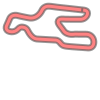

In [3]:
# Replace the name here with the track to analyze
TRACK_NAME = 'arctic_pro'

# Load the center, inner, outer waypoints
waypoints = np.load("./tracks/%s.npy" % TRACK_NAME)

# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly

# Display the original track waypoints

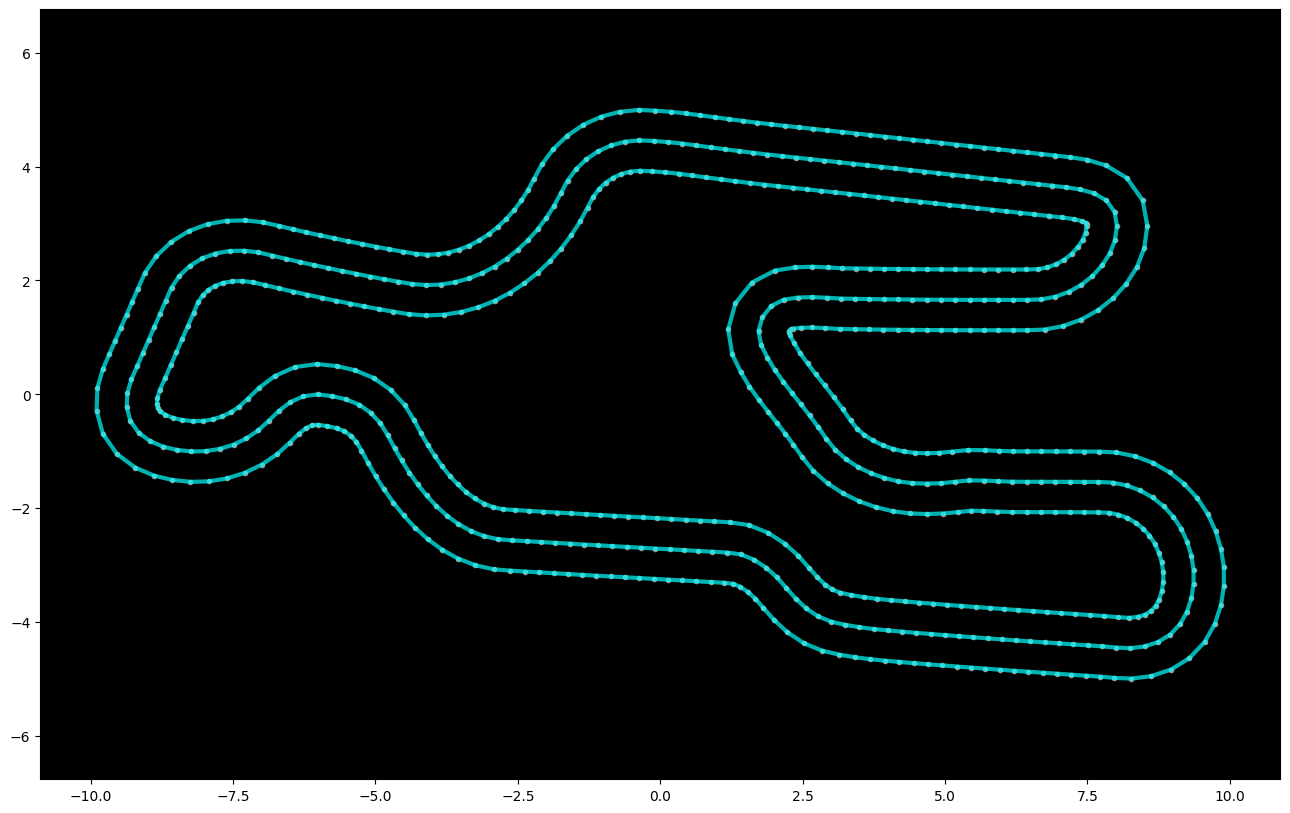

In [4]:
def plot_coords(ax, ob):                                                        
    x, y = ob.xy                                                                
    ax.plot(x, y, '.', color='#999999', zorder=1)                               
                                                                                
def plot_bounds(ax, ob):                                                        
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))                          
    ax.plot(x, y, '.', color='#000000', zorder=1)                               
                                                                                
def plot_line(ax, ob):                                                          
    x, y = ob.xy                                                                
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                                                                                
def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)                                                
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(inner_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)                                                         
                                                                                
    line = LineString(outer_border_waypoints)                                   
    plot_coords(ax, line)                                                       
    plot_line(ax, line)     

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)


In [5]:
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [6]:
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=1000

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

## Calculate the race line!

In [7]:
print(len(center_line))
# start along centerline of track
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)
    if i % 20 == 0: print("Iteration %d" % i)

238
Iteration 0
Iteration 20
Iteration 40
Iteration 60
Iteration 80
Iteration 100
Iteration 120
Iteration 140
Iteration 160
Iteration 180
Iteration 200
Iteration 220
Iteration 240
Iteration 260
Iteration 280
Iteration 300
Iteration 320
Iteration 340
Iteration 360
Iteration 380
Iteration 400
Iteration 420
Iteration 440
Iteration 460
Iteration 480
Iteration 500
Iteration 520
Iteration 540
Iteration 560
Iteration 580
Iteration 600
Iteration 620
Iteration 640
Iteration 660
Iteration 680
Iteration 700
Iteration 720
Iteration 740
Iteration 760
Iteration 780
Iteration 800
Iteration 820
Iteration 840
Iteration 860
Iteration 880
Iteration 900
Iteration 920
Iteration 940
Iteration 960
Iteration 980


These should be the same:  ((238, 2), (238, 2))
Original centerline length: 59.52
New race line length: 52.15


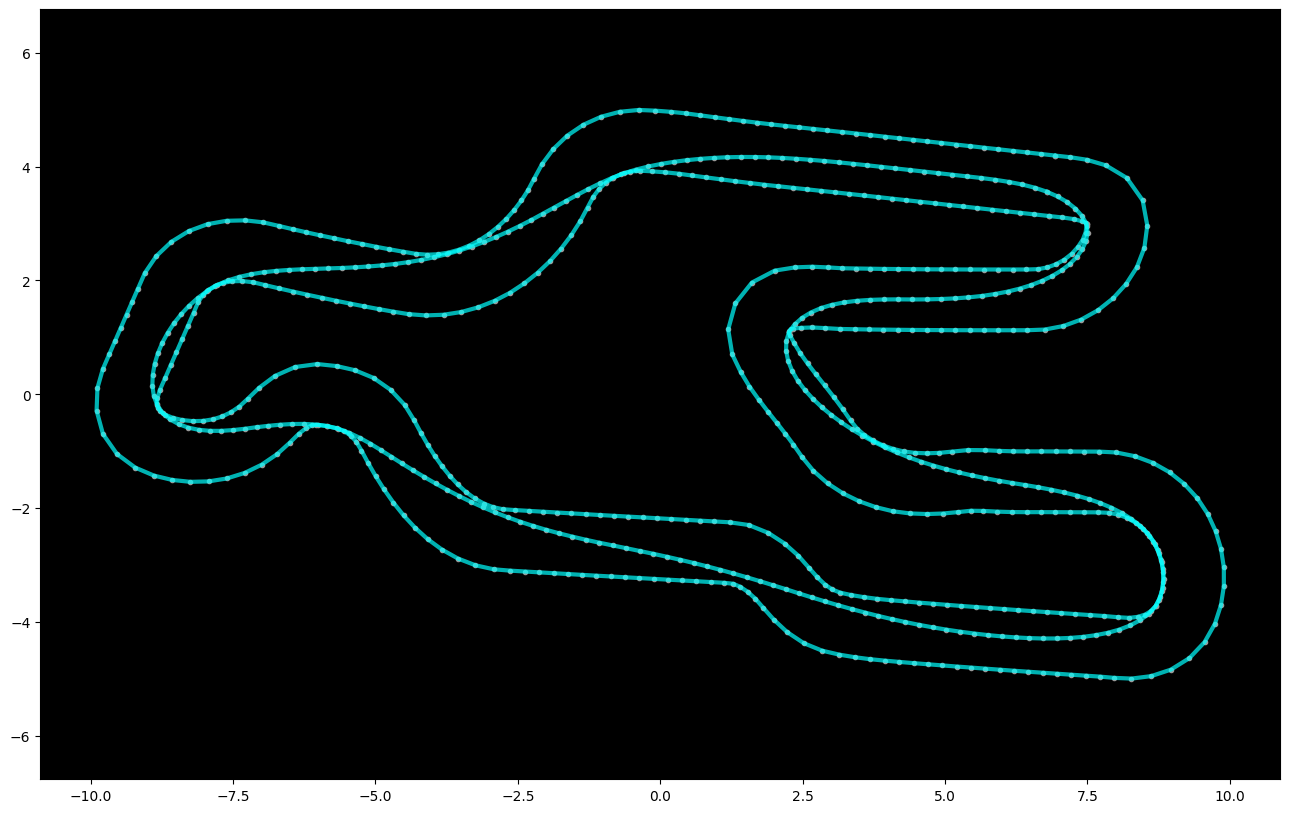

In [8]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

## Save the raceline as:

1. Binary numpy array for loading from a file
2. Text numpy array for pasting directly into a reward function

In [9]:
from datetime import datetime

now = datetime.now()
prefix = f'./racelines/{TRACK_NAME}'
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))
    
print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

Writing python code to ./racelines/arctic_pro.py
Writing numpy binary to ./racelines/arctic_pro.npy


# Load and visualize a stored track file

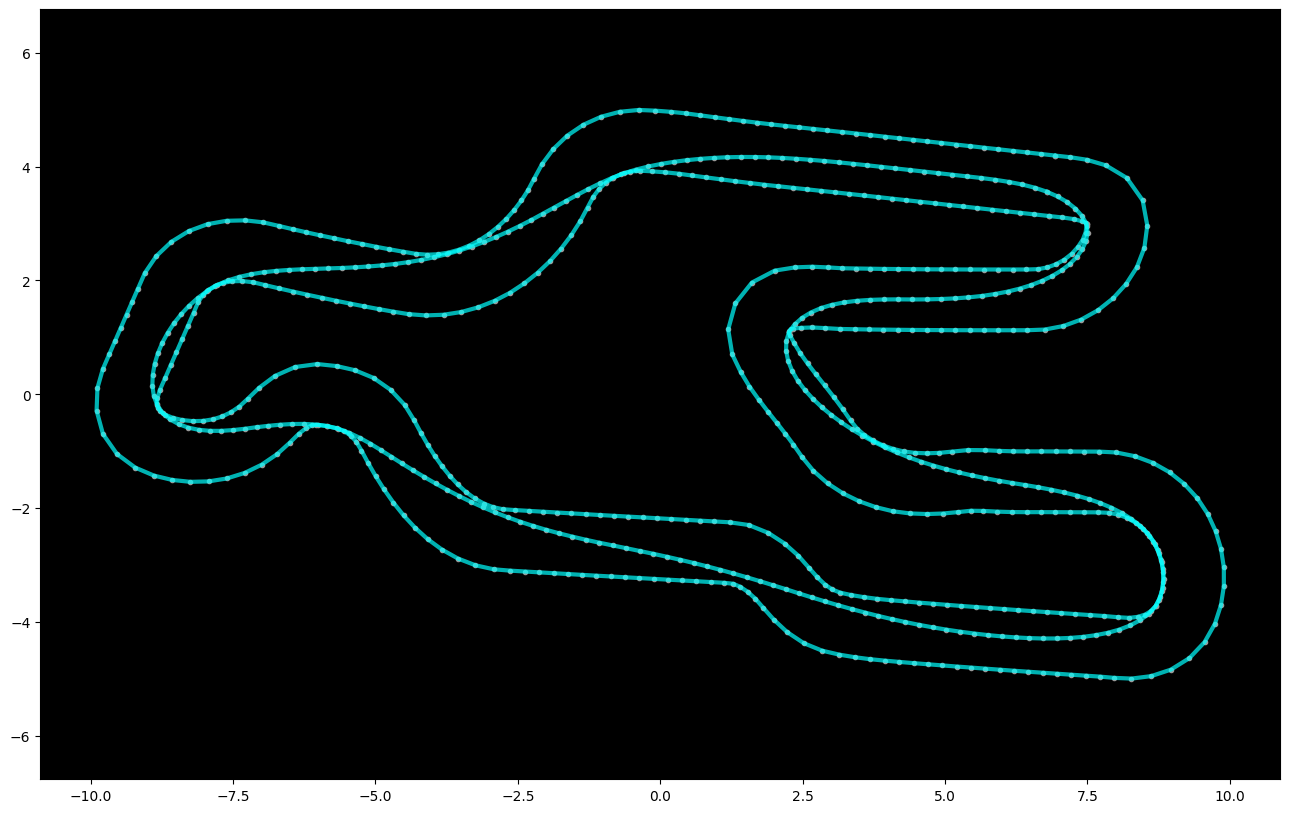

In [10]:
from numpy import array

fname = f'./racelines/{TRACK_NAME}.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
deserialized
fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, deserialized, inner_border, outer_border)

In [11]:
import warnings
import math
from scipy import stats
warnings.filterwarnings('ignore')

In [12]:
fpath = "/home/ethanphan/deepracer/deepracer-analysis/racelines/arctic_pro-1000-4-2023-03-17-173216.npy"
racing_track = np.load(fpath)
racing_track = racing_track.tolist()[:-1]

In [13]:
racing_track

[[6.785728666668721, 3.558375786750458],
 [6.5761826799417715, 3.628026752846391],
 [6.352250693993434, 3.684731936834991],
 [6.117506111640106, 3.7304991160228056],
 [5.875374522615976, 3.767980648821091],
 [5.628427611598839, 3.7995472985106775],
 [5.3790905475616455, 3.8279484510421753],
 [5.129326105117798, 3.8557804822921753],
 [4.8795599937438965, 3.8836164474487305],
 [4.629792928695679, 3.9114575386047363],
 [4.380024433135986, 3.9393035173416138],
 [4.130249977111816, 3.96708345413208],
 [3.8804584741592407, 3.9946409463882446],
 [3.630676025052131, 4.021909508205403],
 [3.381206080330326, 4.048391122546864],
 [3.1321922085261944, 4.073584866975063],
 [2.883793011943579, 4.096955730746866],
 [2.636177229940816, 4.1179579197966625],
 [2.3895252938082225, 4.136033755510605],
 [2.144030284506043, 4.1506121086090335],
 [1.8998982484968872, 4.161108058833202],
 [1.6573990822227351, 4.166774498976352],
 [1.4166414327152106, 4.1673597376868825],
 [1.1778516074311969, 4.16227984027720

In [14]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

In [15]:
LOOK_AHEAD_POINTS = 10
MIN_SPEED = 1.2
MAX_SPEED = 4

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track, 
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed: 1.921963554879037


Constant multiple for optimal speed: 1.921963554879037


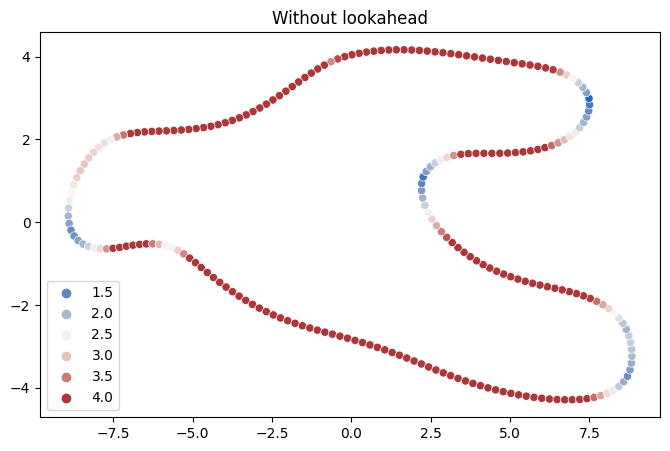

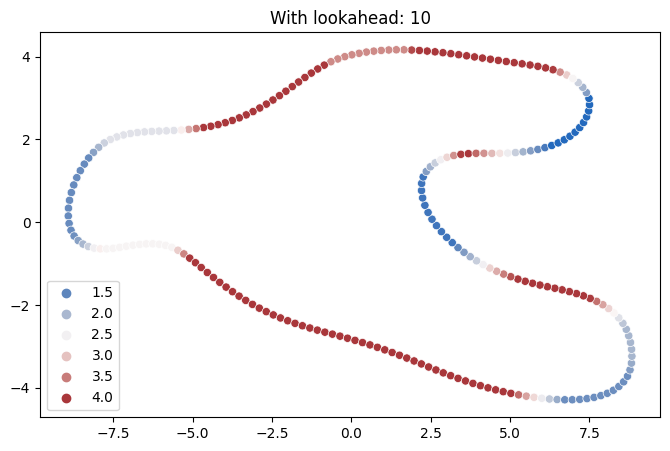

In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

In [17]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)
    
time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 20.250069960385904 s


In [18]:
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

In [19]:
# Write to txt file
with open(f'./optimal_action/optimals_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

# Part 2: Calculate Optimal Action Space

In [20]:
# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1) # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    radius.append(circle_radius(coords))

# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

# Calculate steering with + and -
dist_wheels_front_back = 0.165 # meters
steering = []
for i in range(len(racing_track)):
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    steering.append(steer)
    
# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity":velocity,
                            "steering":steering})

Text(0.5, 1.0, 'With lookahead: 10')

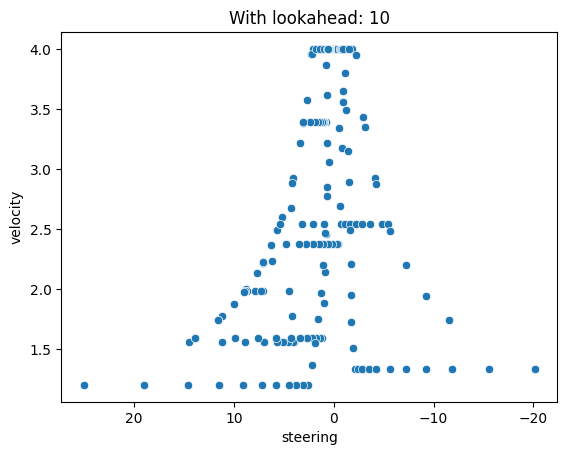

In [21]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")

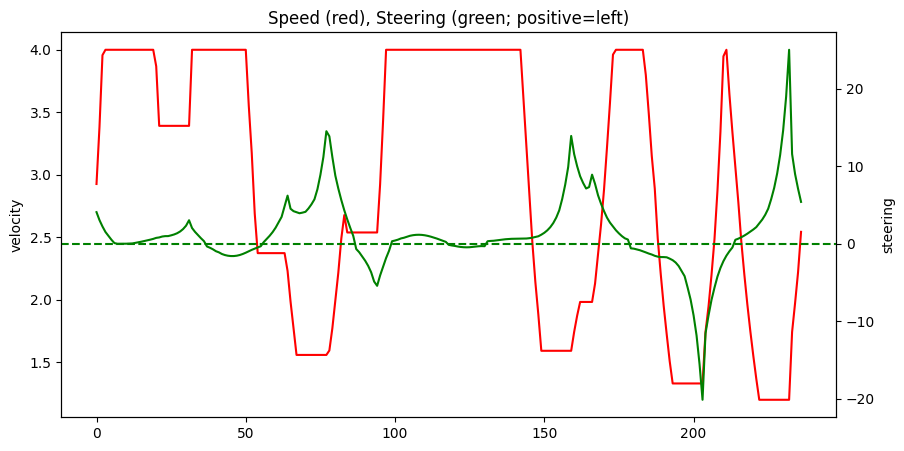

In [22]:
# Visualize all actions
plt.figure(figsize=(10, 5))
sns.lineplot(data=all_actions["velocity"], color="r")
ax2 = plt.twinx()
sns.lineplot(data=all_actions["steering"], color="g", ax=ax2)
plt.axhline(0, ls='--', color="g")
a = plt.title("Speed (red), Steering (green; positive=left)")

<Axes: ylabel='Density'>

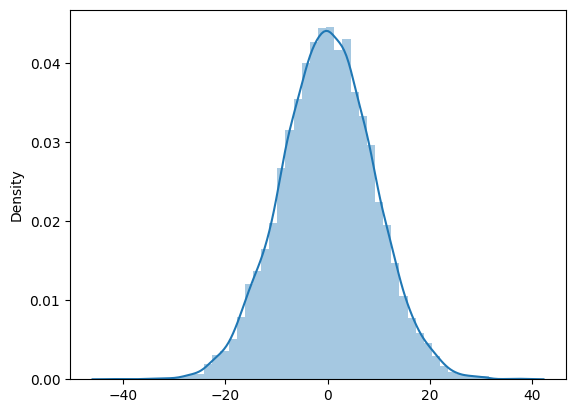

In [25]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)
velocity_sd = -0.25 / stats.norm.ppf(0.00)
sns.distplot(np.random.normal(0,steering_sd,10000))

In [26]:
all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)
    
# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so 
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]
    
# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)


# Display actions shape
all_actions_norm.shape

(173769, 2)

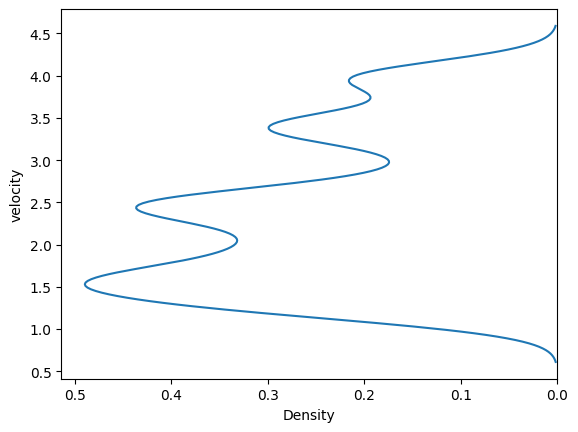

In [27]:
all_actions_norm_less = all_actions_norm.sample(frac=0.01).reset_index(drop=True) # sample bc less compute time
ax = sns.kdeplot(data=all_actions_norm_less["steering"],y=all_actions_norm_less["velocity"])
ax.invert_xaxis()

In [28]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), 
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 21-2
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_), 
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so 
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[MIN_SPEED,MIN_SPEED],"steering":[30,-30]})
X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()

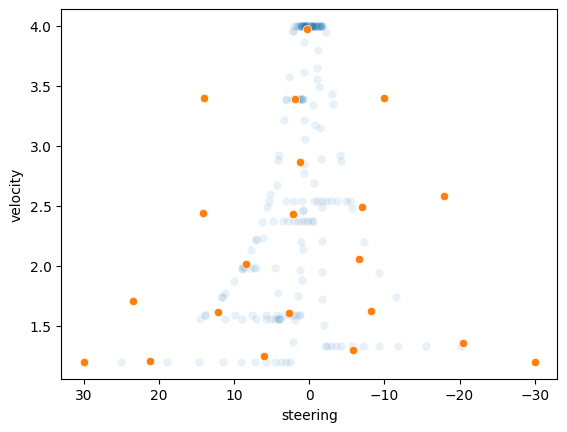

In [29]:
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

*Note: Action space can be different every time it is computed because of randome resampling with gaussian noise and also because of the random seed with K-Means. Therefore, try out multiple iterations until you are happy with the result*

#### Output as JSON format

In [30]:
# Output JSON format
action_space_for_json = action_space_e[["steering","velocity"]].copy()
    
action_space_for_json = action_space_for_json.round(4)
action_space_for_json.columns = ["steering_angle","speed"]
action_space_for_json["index"] = action_space_for_json.index
json_text = action_space_for_json.to_json(orient="records", lines=False)

action_space_for_json

,steering_angle,speed,index
0,12.1023,1.6139,0
1,1.8664,3.3942,1
2,14.1887,2.4441,2
3,2.6417,1.6039,3
4,-7.0279,2.4951,4
5,0.3067,3.9736,5
6,-20.3959,1.3568,6
7,21.2486,1.2109,7
8,-6.5771,2.0590,8
9,8.3693,2.0168,9
